# Test Linear Regression with ADAM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
import sys
sys.path.insert(1, 'Modules/')
from Evaluation_Metric import Metric_regression
from Linear_Regression_ADAM import ADAM, ADAM_learning_rate_decay, ADAM_learning_rate_decay_full_train
from Cross_validation import preparation_cross_validation
golden_section_search = __import__('20220716_Golden_Section_Search').golden_section_search

## 1. Loading data set
The Diabetes dataset is loaded as a toy dataset. 
The different models are compared based on the diabetes dataset. 

Additional information are referred to: https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset (accessed 18th July 2022)


In [3]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

## 2. Standardization of the dataset

In [4]:
X = X - X.mean(axis=0)
X = X / X.var(axis=0)**0.5

## 3. Splitting data in train and test
The models are trained based on the training data. The performance evaluation is performed on the test data. 
Therefore, the data is splitted in train (90 %) and test (10 %).

In [5]:
n_train = int(y.shape[0] * 0.9)
X_train = X[:n_train,:]
y_train = y[:n_train]
X_test =  X[n_train:,:]
y_test = y[n_train:]

## 4. Fitting models to train
First, the reference Linear Regression with analytical solution is performed using the modul **Scikit-learn**.

In [6]:
print('1. Fit direct Linear Regression (Sklearn)')
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_sklearn = np.dot(X_test, lin_reg.coef_) + lin_reg.intercept_

1. Fit direct Linear Regression (Sklearn)


Thereafter, **Ridge Regression** (Scikit-learn) is deployed to the trainingsset.
**Ridge Regression** avoids overfitting with $L^{2}$ regularisation.
The trainings dataset is divided into $n$ subtrain and validation sets. 
Then, the optimal alpha, which minimzes the validation MSE, is found with Cross Validation (CV) for every set.
The CV for $n$ datasets is repeated 100 for decreasing the variance of the optimal alphas.
The optima are found with the **golden section search**. 
The **golden section search** finds the mimimum in a given intervall, for strictly unimodal functions.
The optimal alpha for the training on the full dataset, is set to the mean of all found alphas.

In [7]:
def MSE_alpha (alpha, X_train, y_train, X_val, y_val):
    ridge_ridge = Ridge(alpha=alpha)
    ridge_ridge.fit(X_train, y_train)
    y_val_hat = np.dot(X_val, ridge_ridge.coef_) + ridge_ridge.intercept_
    MSE_ = Metric_regression().fun_MSE(y_val, y_val_hat)
    return (MSE_) 

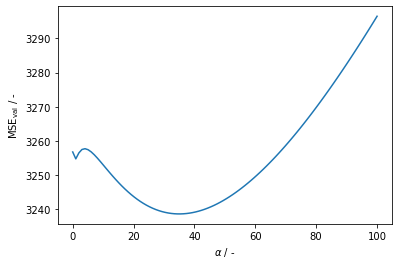

In [8]:
n_split = int(y.shape[0]*0.55)
X_train_1 = X_train[:n_split,:]
y_train_1 = y_train[:n_split]
X_val_1 = X_train[n_split:,:]
y_val_1 = y_train[n_split:]

MSE_min = lambda alpha: MSE_alpha(alpha, X_train=X_train_1, y_train=y_train_1, X_val=X_val_1, y_val=y_val_1)
MSE_min_vec = np.vectorize(MSE_min)
alpha_array = np.linspace(0, 100, 100)
plt.plot(alpha_array, MSE_min_vec(alpha_array))
plt.xlabel(r'$\alpha$ / -')
plt.ylabel('MSE$_{\mathrm{val}}$ / -')
plt.show()

In [9]:
n_bags = 3
n_repetition = 100
alpha_opt_list = []
MSE_mean = 0
for n_rep in range (n_repetition):
    bags_list = preparation_cross_validation(X_train, y_train, n_bags)
    for n_val in range (n_bags):
        X_train_ = []
        y_train_ = []
        X_val_ = np.array(bags_list[n_val].x)
        y_val_ =  np.array(bags_list[n_val].y)
        for n in range (n_bags):
            if n_val != n:
                X_train_ += bags_list[n].x
                y_train_ += bags_list[n].y
        X_train_ = np.array(X_train_)
        y_train_ = np.array(y_train_)

        MSE_min = lambda alpha: MSE_alpha(alpha, X_train=X_train_, y_train=y_train_, X_val=X_val_, y_val=y_val_)
        MSE_min_vec = np.vectorize(MSE_min)
        alpha_opt = golden_section_search(MSE_min, 0, 10000, 1E-8)
        alpha_opt_list.append(alpha_opt)
        MSE_mean += MSE_min(alpha_opt) / n_bags / n_repetition
        #print('MSE (on validation set {}/{}) = {:.2f} | alpha = {:.2g}'.format(n_val+1, n_bags, MSE_min(alpha_opt), alpha_opt))  
best_alpha = np.array(alpha_opt_list)
print('Mean MSE Cross Validation = {:.2f}'.format(MSE_mean))
print('Best alpha = {:.3g} +- {:.3g}'.format(np.mean(best_alpha), best_alpha.var(ddof=1)**0.5))
ridge_reg = Ridge(np.mean(best_alpha))
ridge_reg.fit(X_train, y_train)
y_test_ridge_sklearn = np.dot(X_test, ridge_reg.coef_) + ridge_reg.intercept_

Mean MSE Cross Validation = 3154.19
Best alpha = 33.7 +- 38.8


### Setting the maximum of iteration
4 models based on Stochastic Gradient Descent (SGD) with ADAM are fitted.
The maximum amount of Epoch is set for all SGD models.

In [10]:
max_epoch = 1E5
model_list = []

### SGD with ADAM

In [11]:
Gradient_descent_1 = ADAM(max_epoch=max_epoch, eta=.1, batch_size=1)
print('2. {} on train:'.format(Gradient_descent_1.name))
Gradient_descent_1(X_train, y_train) 
model_list.append(Gradient_descent_1)

2. SGD with Adam on train:
Epoch: 10000 | MSE_train: 3020.46
Epoch: 20000 | MSE_train: 3012.56
Epoch: 30000 | MSE_train: 3005.28
Epoch: 40000 | MSE_train: 3010.19
Epoch: 50000 | MSE_train: 3007.67
Epoch: 60000 | MSE_train: 3010.47
Epoch: 70000 | MSE_train: 3016.50
Epoch: 80000 | MSE_train: 3010.85
Epoch: 90000 | MSE_train: 3006.53
Epoch: 100000 | MSE_train: 3006.27
##################################################


### SGD with ADAM and learning rate decay

In [12]:
Gradient_descent_2 = ADAM_learning_rate_decay(max_epoch=max_epoch, eta=.1, batch_size=1, patience=1E2)
print('3. {} on train:'.format(Gradient_descent_2.name))
Gradient_descent_2(X_train, y_train)
model_list.append(Gradient_descent_2)

3. SGD with ADAM and learning rate decay on train:
New learning rate: 0.032
New learning rate: 0.01
New learning rate: 0.0032
New learning rate: 0.001
New learning rate: 0.00032
New learning rate: 0.0001
New learning rate: 3.2e-05
New learning rate: 1e-05
##################################################


### SGD with ADAM and learning rate decay (evaluation on validation set)

In [13]:
Gradient_descent_2_2 = ADAM_learning_rate_decay(max_epoch=max_epoch, eta=.1, batch_size=1, patience=1E2)
print('4. {} on subtrain:'.format(Gradient_descent_2_2.name))
split = int(X_train.shape[0]*0.8)
Gradient_descent_2_2(X_train[:split], y_train[:split],
                     X_train[split:], y_train[split:]
                     )
model_list.append(Gradient_descent_2_2)

4. SGD with ADAM and learning rate decay on subtrain:
New learning rate: 0.032
New learning rate: 0.01
New learning rate: 0.0032
New learning rate: 0.001
New learning rate: 0.00032
New learning rate: 0.0001
New learning rate: 3.2e-05
New learning rate: 1e-05
##################################################


### SGD with ADAM and learning rate decay (full training)

In [14]:
Gradient_descent_3 = ADAM_learning_rate_decay_full_train(max_epoch=max_epoch, eta=.1, batch_size=1, patience=1E2)
print('6. {} on subtrain and train, respectively:'.format(Gradient_descent_3.name))
Gradient_descent_3(X_train, y_train)
model_list.append(Gradient_descent_3)

6. SGD with ADAM and learning rate decay and full training on subtrain and train, respectively:
New learning rate: 0.032
New learning rate: 0.01
New learning rate: 0.0032
New learning rate: 0.001
New learning rate: 0.00032
New learning rate: 0.0001
New learning rate: 3.2e-05
New learning rate: 1e-05
Start full training!
New learning rate: 0.032
New learning rate: 0.01
New learning rate: 0.0032
New learning rate: 0.001
New learning rate: 0.00032
New learning rate: 0.0001
New learning rate: 3.2e-05
New learning rate: 1e-05
##################################################


## 5. Evaluation of the models
### Comparing the weights and bias

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
compare_weights = pd.DataFrame()
compare_weights['Sklearn'] = np.append(lin_reg.intercept_ , lin_reg.coef_ )
compare_weights['Rdge'] = np.append(ridge_reg.intercept_ , ridge_reg.coef_ )
for SGD_model in model_list:
    column_name = SGD_model.name
    if column_name == 'SGD with Adam':
        w = SGD_model.theta
        w_0 = SGD_model.theta_0
    
    else:
        w = SGD_model.best_theta
        w_0 = SGD_model.best_theta_0
    compare_weights[column_name] = np.append(w_0, w)
pd.set_option('display.precision', 1)
print(compare_weights.T)   

                                                        0        1     2  \
Sklearn                                             152.4 -2.1e-02 -11.3   
Rdge                                                152.3  3.6e-01 -10.0   
SGD with Adam                                       152.5 -2.0e-01 -12.3   
SGD with ADAM and learning rate decay               152.4  3.9e-01 -11.8   
SGD with ADAM and learning rate decay metric on...  152.0  9.4e-03 -12.6   
SGD with ADAM and learning rate decay and full ...  152.0 -5.7e-02 -12.5   

                                                       3     4     5     6  \
Sklearn                                             24.7  14.5 -35.8  20.4   
Rdge                                                23.4  13.5  -4.7  -3.0   
SGD with Adam                                       24.4  14.8 -63.1  40.5   
SGD with ADAM and learning rate decay               24.0  14.7 -53.0  33.7   
SGD with ADAM and learning rate decay metric on...  24.6  13.2 -43.9  25.4   

### Model Performance
The Mean Squared Error (MSE) on the test data set is compared.
In addition, the increase in MSE is referenced to the analytical solution.

In [16]:
MSE_compare = pd.Series(dtype=float)
ARD_compare = pd.Series(dtype=float) 
MSE_sklearn = Metric_regression().fun_MSE(y_test, y_test_sklearn)
MSE_ridge = Metric_regression().fun_MSE(y_test, y_test_ridge_sklearn)
MSE_compare['Sklearn'] = MSE_sklearn
MSE_compare['Ridge'] = MSE_ridge
ARD_compare['Sklearn'] = 0
ARD_compare['Ridge'] = -(MSE_ridge - MSE_sklearn)  / MSE_sklearn*100
for SGD_model in model_list:
    column_name = SGD_model.name
    MSE_test = SGD_model.MSE(X_test, y_test)
    MSE_compare[column_name] = MSE_test
    ARD_compare[column_name] = -(MSE_test-MSE_sklearn) / MSE_sklearn*100

MSE_DF = MSE_compare.to_frame(name='MSE')
ARD_DF = ARD_compare.to_frame(name='Deviation / %')
performance_DF = pd.concat([ARD_DF, MSE_DF], axis=1)
print(performance_DF)

                                                    Deviation / %     MSE
Sklearn                                                       0.0  1735.9
Ridge                                                        -6.2  1843.9
SGD with Adam                                                 2.4  1695.0
SGD with ADAM and learning rate decay                         2.6  1690.3
SGD with ADAM and learning rate decay metric on...            5.0  1648.8
SGD with ADAM and learning rate decay and full ...            5.0  1648.9


The analytical solution of the **Linear Regression** is set to the baseline of the models. 
SDG with ADAM improves the performance of the test MSE.
Allthough SGD with ADAM is adaptive, the performance increases rises from **4.2 %** to **5.0 %** when applying learning rate decay. 
In case of SGD with ADA; and leraning rate decay, the MSE increase improves fom **2.6 %** to **5.0 %** if the metric is applied on the validation dataset.
Therefore, Early Stopping must be evaluated on a validation dataset to avoid overfitting.

Interestingly, for this particular dataset the **Ridge Regression** seems not to improve the error on the test set. 
Probably, the high  standard deviation of the optimized alpha **(33.7 +- 38.8)** causes a non optimal selection of the alpha. A different regulariation, e.g. Lasso or Elastic Net, may improve the performance on the test dataset.